In [1]:
import os
import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from jax import vmap
import jax.numpy as jnp
import jax.random as random
import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, HMCGibbs
from tqdm import tqdm_notebook
import plotly.graph_objects as go
from numpyro.infer.initialization import init_to_value

numpyro.util.set_rng_seed(0)
numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

In [2]:
# Create folder for storing results

time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
new_dir = os.path.join("../../output/1d_reg/", "numpyro_c_" + time)
os.mkdir(new_dir)

In [3]:
ITER = 50000
CHAINS = 4

In [4]:
def load_data():

    # Load Data

    df = pd.read_table("../../data/rdata", header=None, delim_whitespace=True)
    df.columns = ["X", "Y"]
    df["index"] = np.where(df.index < 100, "Train", "Test")

    # Create train and test

    X_train = np.array(df.loc[df["index"] == "Train", "X"]).reshape(-1, 1)
    Y_train = np.array(df.loc[df["index"] == "Train", "Y"])
    X_test = np.array(df.loc[df["index"] == "Test", "X"]).reshape(-1, 1)
    Y_test = np.array(df.loc[df["index"] == "Test", "Y"])

    return X_train, X_test, Y_train, Y_test

In [5]:
X_train, X_test, Y_train, Y_test = load_data()
_X_train = jnp.array(X_train.reshape((len(Y_train), 1)))
_Y_train = jnp.array(Y_train.reshape((len(Y_train), 1)))

In [6]:
def model(x, y):
    
    # Hyperparameters
    
    w_ih_prec = numpyro.sample("w_ih_prec", dist.Gamma(0.25, 0.000625))
    b_h_prec = numpyro.sample("b_h_prec", dist.Gamma(0.25, 0.000625))
    w_ho_prec = numpyro.sample("w_ho_prec", dist.Gamma(0.25, 7.8125e-05))
    y_prec = numpyro.sample("y_prec", dist.Gamma(0.25, 0.000625))
    
    # Low Level Parameters

    w_ih = numpyro.sample("w_ih", dist.Normal(loc=jnp.zeros((1, 8)), scale=1/jnp.sqrt(w_ih_prec)))
    b_h = numpyro.sample("b_h", dist.Normal(loc=jnp.zeros((1, 8)), scale=1/jnp.sqrt(b_h_prec)))
    w_ho = numpyro.sample("w_ho", dist.Normal(loc=jnp.zeros((8, 1)), scale=1/jnp.sqrt(w_ho_prec)))
    b_o = numpyro.sample("b_o", dist.Normal(loc=jnp.zeros((1, 1)), scale=100))
    
    # Forward Pass

    z1 = jnp.matmul(x, w_ih) + b_h
    a1 = jnp.tanh(z1)
    output = jnp.matmul(a1, w_ho) + b_o
    
    return numpyro.sample("y_pred", dist.Normal(output, 1/jnp.sqrt(y_prec)), obs=y)

In [7]:
def fbm_gamma_params_to_stan(fbm_width, fbm_alpha, N=1.):

    mean_precision = (N) / (fbm_width ** 2)

    # Convert to Stan parametrization

    gamma_alpha = fbm_alpha / 2
    gamma_beta = gamma_alpha / mean_precision

    return gamma_alpha, gamma_beta

fbm_gamma_params_to_stan(0.05, 0.5, 8)

(0.25, 7.812500000000002e-05)

In [8]:
def gibbs_fn(rng_key, gibbs_sites, hmc_sites):
    
    """
    Condition probablities for the precision of each group
    P(precision | parameters) = Gamma(alpha, beta)
    Check alpha, beta calculations
    """
    
    # w_ih_prec
    
    w_ih = hmc_sites['w_ih']
    alpha_ih = (0.5 + 8)/2
    beta_ih = 0.5*((0.5*(0.05**2)) + jnp.sum(jnp.square(w_ih)))
    new_w_ih_prec = dist.Gamma(alpha_ih, beta_ih).sample(rng_key)
    
    # b_h_prec
    
    b_h = hmc_sites['b_h']
    alpha_h = (0.5 + 8)/2
    beta_h = 0.5*((0.5*(0.05**2)) + jnp.sum(jnp.square(b_h)))
    new_b_h_prec = dist.Gamma(alpha_h, beta_h).sample(rng_key)
    
    # w_ho_prec
    
    w_ho = hmc_sites['w_ho']
    alpha_ho = (0.5 + 8)/2
    beta_ho = 0.5*((0.5*(0.05**2)/8) + jnp.sum(jnp.square(w_ho)))
    new_w_ho_prec = dist.Gamma(alpha_ho, beta_ho).sample(rng_key)
    
    # y_prec
    
    z1 = jnp.matmul(_X_train, w_ih) + b_h
    a1 = jnp.tanh(z1)
    output = jnp.matmul(a1, w_ho) + hmc_sites['b_o']
    
    alpha_noise = (0.5 + 100)/2
    beta_noise = 0.5*(0.5*(0.05**2) + jnp.sum(jnp.square(output - _Y_train)))
    new_y_prec = dist.Gamma(alpha_noise, beta_noise).sample(rng_key)
    
    return {'w_ih_prec': new_w_ih_prec, 
            'b_h_prec': new_b_h_prec, 
            'w_ho_prec': new_w_ho_prec,
            'y_prec': new_y_prec}

In [9]:
init_values = {
    
    "w_ih_prec": 1.,
    "b_h_prec": 1.,
    "w_ho_prec": 1.,
    "y_prec": 1.,
    "w_ih": jnp.zeros((1, 8)),
    "b_h": jnp.zeros((1, 8)),
    "w_ho": jnp.zeros((8, 1)),
    "b_o": jnp.zeros((1, 1))
    
}

In [10]:
# Set random key 

rng_key = random.PRNGKey(42)
rng_key, rng_key_predict = random.split(rng_key)

# Initialize NUTS for low-level parameters

nuts_kernel = NUTS(model, adapt_mass_matrix=True, 
                  init_strategy = init_to_value(values=init_values))

# Wrap NUTS inside the Gibbs update for hyperparameters

kernel = HMCGibbs(nuts_kernel, 
                  gibbs_fn=gibbs_fn, 
                  gibbs_sites=['w_ih_prec', 'b_h_prec', 'w_ho_prec', 'y_prec'])

# Instantiate MCMC

mcmc = MCMC(kernel,
            num_samples=ITER,
            num_warmup=1000,
            num_chains=4,
            progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True)

mcmc.run(rng_key,
         jnp.array(X_train.reshape((len(Y_train), 1))), 
         jnp.array(Y_train.reshape((len(Y_train), 1))))

mcmc.print_summary()

# Get dict of samples

samples = mcmc.get_samples()






                 mean       std    median      5.0%     95.0%     n_eff     r_hat
   b_h[0,0]      0.04      5.23      0.01     -7.99      7.31   3862.88      1.00
   b_h[0,1]     -0.03      5.48     -0.06     -7.81      7.87   3110.82      1.00
   b_h[0,2]      0.09      5.10      0.11     -7.59      7.72   4310.12      1.00
   b_h[0,3]     -0.14      5.23     -0.19     -7.76      7.45   4320.54      1.00
   b_h[0,4]      0.06      5.35      0.02     -8.05      7.75   2979.65      1.00
   b_h[0,5]     -0.16      5.34     -0.04     -8.02      7.62   3329.04      1.00
   b_h[0,6]     -0.07      5.26     -0.03     -7.84      7.58   3864.02      1.00
   b_h[0,7]     -0.10      5.21     -0.04     -7.79      7.46   5800.69      1.00
   b_h_prec      0.09      0.09      0.06      0.00      0.20   4623.22      1.01
   b_o[0,0]      0.78      2.20      0.75     -2.56      3.28    868.50      1.01
  w_ho[0,0]      0.01      1.37     -0.03     -1.71      1.54    680.53      1.00
  w_ho[1,0]

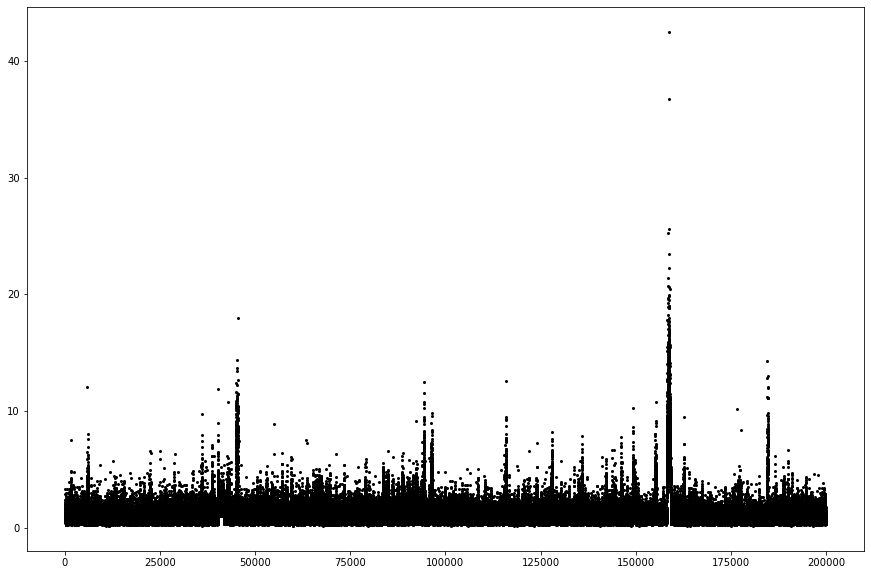

In [11]:
plt.figure(figsize = (15,10))
plt.plot(1/jnp.sqrt(samples["w_ho_prec"]), "ko", markersize=2)

In [12]:
# TODO: can we make this more like tf_probability? The vmap function speeds it up.

def predict(model, rng_key, samples, X):
    
    model = handlers.substitute(handlers.seed(model, rng_key), samples)
    
    # note that Y will be sampled in the model because we pass Y=None here
    
    model_trace = handlers.trace(model).get_trace(x=X, y=None)
    
    return model_trace['y_pred']['value']

In [13]:
# Train and Test Predictions

# vmap_args = (samples, random.split(rng_key_predict, ITER * CHAINS))
# train_predictions = vmap(lambda samples, rng_key: predict(model, rng_key, samples, X_train))(*vmap_args)
# test_predictions = vmap(lambda samples, rng_key: predict(model, rng_key, samples, X_test))(*vmap_args)
# y_train_pred = train_predictions[..., 0]
# y_test_pred = test_predictions[..., 0]

# df_predictions_train = pd.DataFrame({
    
#     "inputs": X_train.flatten(),
#     "targets": Y_train.flatten(),
#     "mean": y_train_pred[100:, :].mean(axis=0),
#     "median": np.quantile(y_train_pred, 0.5, axis=0),
#     "q1": np.quantile(y_train_pred, 0.01, axis=0),
#     "q10": np.quantile(y_train_pred, 0.10, axis=0),
#     "q90": np.quantile(y_train_pred, 0.90, axis=0),
#     "q99": np.quantile(y_train_pred, 0.99, axis=0),
#     "label": "train"

# })

# df_predictions_test = pd.DataFrame({
    
#     "inputs": X_test.flatten(),
#     "targets": Y_test.flatten(),
#     "mean": y_test_pred.mean(axis=0),
#     "median": np.quantile(y_test_pred, 0.5, axis=0),
#     "q1": np.quantile(y_test_pred, 0.01, axis=0),
#     "q10": np.quantile(y_test_pred, 0.10, axis=0),
#     "q90": np.quantile(y_test_pred, 0.90, axis=0),
#     "q99": np.quantile(y_test_pred, 0.99, axis=0),
#     "label": "test"

# })

# df = df_predictions_train.copy(deep=True)
# df = df.sort_values("inputs").reset_index()

# fig = go.Figure([
#     go.Scatter(
#         name='median',
#         x=df['inputs'],
#         y=df['median'],
#         mode='lines',
#         line=dict(color='rgb(31, 119, 180)'),
#     ),
#     go.Scatter(
#         name='Upper Bound',
#         x=df['inputs'],
#         y=df['q1'],
#         mode='lines',
#         marker=dict(color="#444"),
#         line=dict(width=0),
#         showlegend=False
#     ),
#     go.Scatter(
#         name='Lower Bound',
#         x=df['inputs'],
#         y=df['q99'],
#         marker=dict(color="#444"),
#         line=dict(width=0),
#         mode='lines',
#         fillcolor='rgba(68, 68, 68, 0.3)',
#         fill='tonexty',
#         showlegend=False
#     )
# ])

# fig.add_scatter(x=df['inputs'], y=df['targets'], mode="markers")

# fig.update_layout(
#     yaxis_title='Y',
#     title='Training Set',
#     hovermode="x"
# )
# fig.show()

In [14]:
# df = df_predictions_test.copy(deep=True)
# df = df.sort_values("inputs").reset_index()

# fig = go.Figure([
#     go.Scatter(
#         name='median',
#         x=df['inputs'],
#         y=df['median'],
#         mode='lines',
#         line=dict(color='rgb(31, 119, 180)'),
#     ),
#     go.Scatter(
#         name='Upper Bound',
#         x=df['inputs'],
#         y=df['q1'],
#         mode='lines',
#         marker=dict(color="#444"),
#         line=dict(width=0),
#         showlegend=False
#     ),
#     go.Scatter(
#         name='Lower Bound',
#         x=df['inputs'],
#         y=df['q99'],
#         marker=dict(color="#444"),
#         line=dict(width=0),
#         mode='lines',
#         fillcolor='rgba(68, 68, 68, 0.3)',
#         fill='tonexty',
#         showlegend=False
#     )
# ])

# fig.add_scatter(x=df['inputs'], y=df['targets'], mode="markers")

# fig.update_layout(
#     yaxis_title='Y',
#     title='Training Set',
#     hovermode="x"
# )
# fig.show()

In [15]:
# Low-level parameters

df_wih = pd.DataFrame(samples['w_ih'].reshape(ITER*CHAINS, 8))
df_bh = pd.DataFrame(samples['b_h'].reshape(ITER*CHAINS, 8))
df_who = pd.DataFrame(samples['w_ho'].reshape(ITER*CHAINS, 8))
df_bo = pd.DataFrame(samples['b_o'].reshape(ITER*CHAINS, 1))

df_wih.columns = ["w_ih_" + str(i) for i in range(0,8)]
df_bh.columns = ["b_h_" + str(i) for i in range(0, 8)]
df_who.columns = ["w_ho_" + str(i) for i in range(0, 8)]
df_bo.columns = ["b_o_" + str(i) for i in range(1, 2)]

df_traces = pd.concat([df_wih, df_bh, df_who, df_bo], ignore_index=False, axis=1)

# High level parameters

df_traces["W_prec_ih"] = samples['w_ih_prec'].reshape(ITER*CHAINS,)
df_traces["B_prec_h"] = samples['b_h_prec'].reshape(ITER*CHAINS,)
df_traces["W_prec_ho"] = samples['w_ho_prec'].reshape(ITER*CHAINS,)
df_traces["y_prec"] = samples['y_prec'].reshape(ITER*CHAINS,)
df_traces["trace"] = 1

df_traces["id"] = df_traces.index

df_traces["trace"] = np.where(np.logical_and(df_traces["id"] >= 0, df_traces["id"] < ITER), 1, 
                                  np.where(np.logical_and(df_traces["id"] >= ITER, df_traces["id"] < 2*ITER), 2, 
                                      np.where(np.logical_and(df_traces["id"] >= 2*ITER, df_traces["id"] < 3*ITER), 3, 
                                              np.where(np.logical_and(df_traces["id"] >= 3*ITER, df_traces["id"] < 4*ITER), 4, 0))))

In [16]:
# Write results to disk

df_traces.to_feather(f"{new_dir}/df_traces.feather")

# Write predictions to disk

# df_predictions = pd.concat([df_predictions_train, df_predictions_test]).reset_index()
# df_predictions.drop(f"index", axis=1).to_feather(f"{new_dir}/df_predictions.feather")

In [17]:
print(new_dir)

../../output/1d_reg/numpyro_c_2021_05_28_12_47_20
